In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Questions

1. Can you estimate the impact the program had on the site?
2. what is a suggested next step
3. Risk of the approach? Better way to test

### Read data and some inspections

In [2]:
data = pd.read_csv("referral.csv")
print("data has shape: ", data.shape)
print("Number of unique users: {}".format(len(data['user_id'].unique())))
print("Number of unique dates: ", len(data['date'].unique()))
print("Number of unique device: ", len(data['device_id'].unique()))

data has shape:  (97341, 6)
Number of unique users: 18809
Number of unique dates:  56
Number of unique device:  17887


In [3]:
#check null
data.isnull().sum()

user_id        0
date           0
country        0
money_spent    0
is_referral    0
device_id      0
dtype: int64

In [4]:
#convert datetime
data['date'] = pd.to_datetime(data['date'])
#create a column after_referral to indicate if transaction happened before referral 
#program starts or after
data['after_referral'] = data['date'].apply(lambda d: 0 if d < pd.datetime(2015,10,31) else 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 7 columns):
user_id           97341 non-null int64
date              97341 non-null datetime64[ns]
country           97341 non-null object
money_spent       97341 non-null int64
is_referral       97341 non-null int64
device_id         97341 non-null object
after_referral    97341 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 5.2+ MB


In [5]:
data.head(3)

,user_id,date,country,money_spent,is_referral,device_id,after_referral
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG,0
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX,0
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG,0


In [6]:
october = data[data['after_referral'] == 0]
november = data[data['after_referral'] == 1]

# Exploratory data analysis 

**is_referral**<br\>

Text(0.5,1,'Distribution of money spent by referred and not referred users')

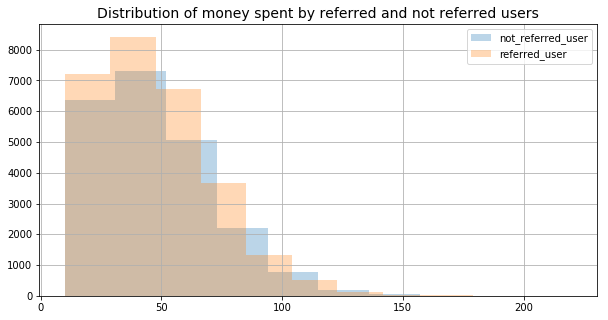

In [8]:
fig, ax = plt.subplots(figsize = (10,5))
november.groupby('is_referral')['money_spent'].hist(alpha = 0.3)
ax.legend(['not_referred_user', 'referred_user'])
ax.set_title("Distribution of money spent by referred and not referred users", fontsize = 14)

**money spent**<br\>

C:\Users\sz\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of money_spent in November')

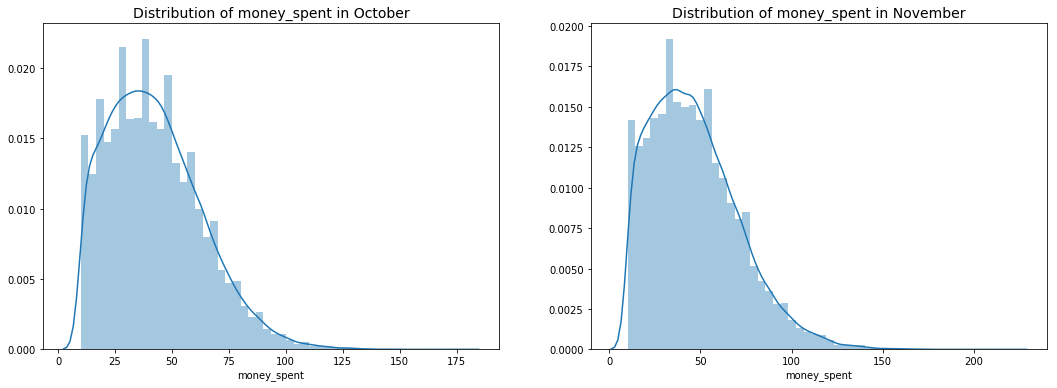

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))

sns.distplot(a=october['money_spent'], hist = True, ax = ax[0])
ax[0].set_title("Distribution of money_spent in October", fontsize = 14)

sns.distplot(a =november['money_spent'], hist= True,ax= ax[1])
ax[1].set_title("Distribution of money_spent in November", fontsize = 14)

**country** <br\> Based on figures below, FR, UK, MX, IT, ES all have increases in users, but CA, US, DE,CH have decreases, and DE has biggest rate of decrease

Text(0.5,1,'Referral rate by country')

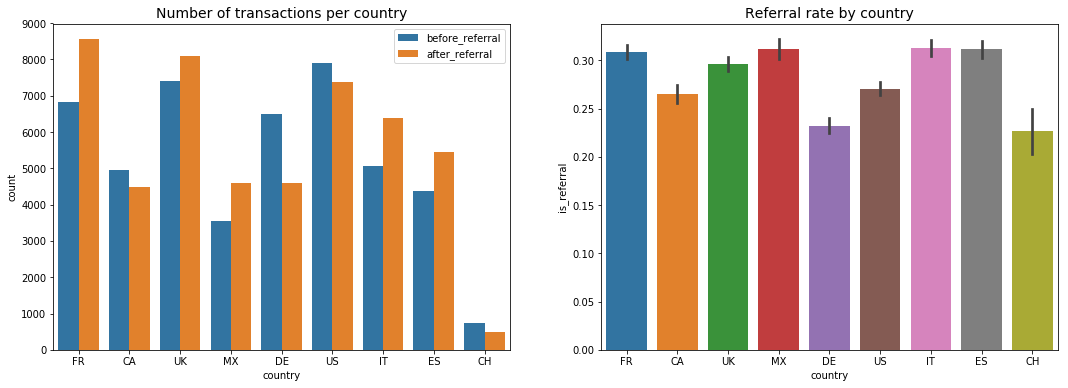

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18,6))

sns.countplot(x = 'country', hue = 'after_referral', data= data, ax = ax[0])
ax[0].legend(['before_referral','after_referral'])
ax[0].set_title("Number of transactions per country", fontsize = 14)

sns.barplot(x = 'country', y = 'is_referral', data = data, ax=ax[1])
ax[1].set_title('Referral rate by country', fontsize= 14)

We see that users from China spent way more than users from other countries, and MX users spent relatively less

Text(0,0.5,'Average money spent')

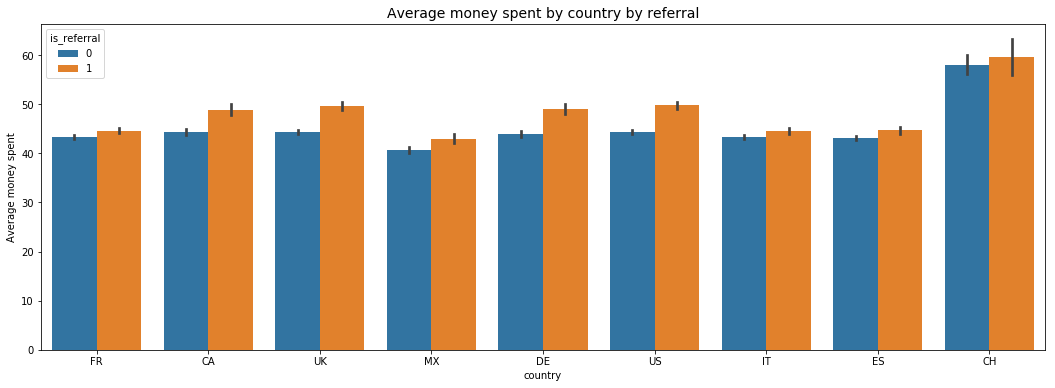

In [10]:
#check average money spent by country
fig, ax = plt.subplots(figsize = (18,6))

sns.barplot(x = 'country', y='money_spent', hue = 'is_referral', data = data)
ax.set_title("Average money spent by country by referral", fontsize = 14)
ax.set_ylabel("Average money spent")

**date**<br\> There are much more transactions on weekends than on workdays

Text(0.5,1,'Average money spent per day')

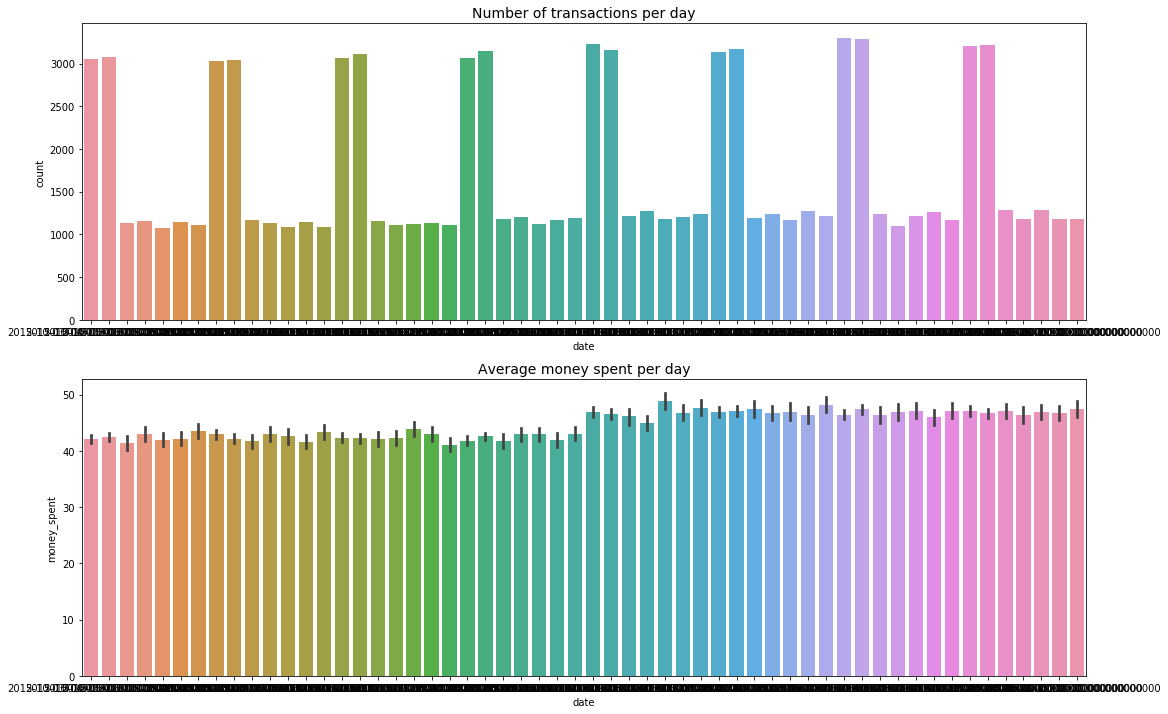

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize = (18,12))

sns.countplot(x = 'date', ax = ax[0], data = data)
ax[0].set_title("Number of transactions per day", fontsize = 14)

sns.barplot(x = 'date', y = 'money_spent', ax = ax[1], data=data)
ax[1].set_title('Average money spent per day', fontsize = 14)

## Q1

We measure the impact by defining following metrics <br\> 
1. average number of transctions per day before and after program  <br\> 
2. average number of new users per day before and after program <br\> 
3. average money spent per user before and after program <br\> 

These metrics need to validated through t-test.<br\>Results:
1. For metric 1, p-value is 0.348, which is above 95% significance level, so we cannot say there is any change in terms of daily transaction number
2. For metric 2, p-value is quite close to 0.05 significance level, meaning that there may be a potential change. However, additional tests or data are required to reach a final conclusion
3. For metric 3, p-value is way below 0.05, and we can conclude that there is a change after referral program starts in terms of average money spent per use <br\>

Overall conclusions
We need to look at two perspectives when reaching to the final conclusion: One is to analyze the impact on user growth or transaction growth. Second is to analyze the impact on money spent <br\>

1. When we analyze first perspective with metrics 1 and 2, we don't see a statistically significant impact on whole data. However, for countries except CA, UK, US, this impact does exist
2. When analyzing second perspective using metrics 3, we see a statistically significant impact on whole data, meaning that after this referral program starts, people are actually spending more on items

In [40]:
from scipy.stats import ttest_ind

def get_daily_stats(df):
    #calculate metrics 1 and 2
    no_trans = df['user_id'].count()
    no_users = df['user_id'].nunique()
    return pd.Series([no_trans, no_users], index = ['no_trans_per_day','unique_users_per_day'])

def get_user_stats(df):
    #calculate metrics 3
    money_spent = df['money_spent'].mean()
    return pd.Series([money_spent], index = ['avg_spent_per_user'])

def get_p_value(df1, df2):
    daily_before_df = df1.groupby('date').apply(get_daily_stats).reset_index()
    daily_after_df = df2.groupby('date').apply(get_daily_stats).reset_index()
    cols = ['no_trans_per_day','unique_users_per_day']
    for i, col in enumerate(cols):
        b_val = daily_before_df[col]
        a_val = daily_after_df[col]
        p_val = ttest_ind(a_val, b_val)[1]/2
        print("Metric {}: {}, p-value: {}".format(i+1, col, p_val))
    
    user_before_df = df1.groupby('user_id').apply(get_user_stats).reset_index()
    user_after_df = df2.groupby('user_id').apply(get_user_stats).reset_index()
    print("Metric 3: avg_spent_per_user, p-value: {}".format(ttest_ind(user_before_df.avg_spent_per_user, \
                                                    user_after_df.avg_spent_per_user)[1]/2))

In [41]:
get_p_value(october, november)

Metric 0: no_trans_per_day, p-value: 0.3482562686588173
Metric 1: unique_users_per_day, p-value: 0.0592422138754325
Metric 3: avg_spent_per_user, p-value: 1.2935226449711397e-72


## country wise analysis

In [52]:
START_TIME = pd.datetime(2015,10,31)
def country_daily_pval(df):
    #daily stat dfs
    daily_df = df.groupby('date').apply(get_daily_stats).reset_index()
    daily_before_df = daily_df[daily_df['date'] < START_TIME]
    daily_after_df = daily_df[daily_df['date'] >= START_TIME]
    #record metrics and p-value
    cols = ['no_trans_per_day','unique_users_per_day']
    p_vals = []
    for col in cols:
        b_val = daily_before_df[col]
        a_val = daily_after_df[col]
        p_vals.append(ttest_ind(a_val, b_val)[1]/2)
    return pd.Series(p_vals, index = cols)

data.groupby('country').apply(country_daily_pval).reset_index()

,country,no_trans_per_day,unique_users_per_day
0,CA,0.233965,0.268249
1,CH,0.002971,0.003046
2,DE,0.011541,0.015440
3,ES,0.072557,0.057836
4,FR,0.058880,0.040959
5,IT,0.057303,0.043720
6,MX,0.032346,0.026105
7,UK,0.261181,0.204385
8,US,0.307800,0.368860


## Q2

1. After program starts, we see a drastic decrease in number of transactions in few countries, especially in DE. So we might need to look at DE sites and see if there is any bugs from the program that results in some website visiting inconvenience
2. Becuase p-value of two metrics for different country varies, we can also analyze the cultural difference between CA,US,UK and other countries. 
3. We need to design more rigorous a/b test

## Q3

This is not a rigorous a/b testing approach because <br\>
1. users are not randomly assigned to experiment and control group. A timeline separates them
2. The experiment duration of two groups is different, and other factors such as holiday could have impact on one duration or another <br\>

A more rigorous approach works as follows:
1. Use the same timeline for both group of users
2. randomly split user to either group
3. After collecting enough data, run t-test to check significance level of above metrics